In [5]:
#Train model
from sklearn.model_selection import train_test_split
import os
import random

import tensorflow as tf
import cv2
import numpy as np
#Import Unet model from segmentation_models 
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import segmentation_models as sm

#Import lib for run wandb
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

sm.set_framework("tf.keras")
sm.framework()


Segmentation Models: using `keras` framework.


'tf.keras'

In [7]:
#Data loader
#Initializer parameters
data_folder = r"train\train"
label_folder = r"train_gt\train_gt"
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)
batch_size = 16
w, h = 384, 384

# Load data follow batch_size and image_size
class Dataset:
    def __init__(self, image_path, mask_path, w, h):
        # the paths of images
        self.image_path = image_path
        # the paths of segmentation images
        self.mask_path = mask_path

        self.w = w
        self.h = h

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.image_path[i])
        image = cv2.resize(image, (self.w, self.h), interpolation=cv2.INTER_AREA)
        image = preprocess_input(image)

        mask = cv2.imread(self.mask_path[i], cv2.IMREAD_UNCHANGED)

        tmp = np.zeros_like(mask)
        tmp1 = np.where(mask[:,:, 1] > 200, 255, 0) + np.where(mask[:,:, 2] > 200, 255, 0)
        tmp[:,:, 0] = np.where(tmp1 > 50, 0, 255)
        tmp[:,:, 1] = np.where(mask[:, :, 1] > 200, 255, 0)
        tmp[:,:, 2] = np.where(mask[:, :, 2] > 200, 255, 0)

        image_mask = cv2.resize(tmp, (w, h), interpolation=cv2.INTER_AREA)
        
        #normalization
        mask_image = np.where(image_mask > 100, 1, 0)
        

        mask_image = [(mask_image == v) for v in [1]]
        mask_image = np.stack(mask_image, axis=-1).astype('float')

        return image, mask_image

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size,shape, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shape = shape
        self.indexes = np.arange(self.shape)

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

#  Load data from folder dataset for create image_path, mask_path
def load_path(data_folder = data_folder):

    # Lay data_path va label_path tuong ung
    data_path = []
    label_path = []
    for file in os.listdir(data_folder):
        if (file.endswith("png") or file.endswith("jpeg")) and (not file.startswith(".")):
            image_path = os.path.join(data_folder, file)
            mask_path = os.path.join(label_folder, file)
            label_path.append(mask_path)
            data_path.append(image_path)

    return data_path, label_path

# Load path to variables
data_path, label_path = load_path()

#train test split
image_train, image_val, mask_train, mask_val = train_test_split(data_path, label_path, test_size = 0.25)

#Create data set and data loader
train_dataset = Dataset(image_train, mask_train, w, h)
val_dataset = Dataset(image_val, mask_val, w, h)

#Loader
train_loader = Dataloader(train_dataset, batch_size, shape = len(image_train), shuffle = True)
val_loader = Dataloader(val_dataset, batch_size, shape = len(image_val), shuffle = True)

In [4]:
Dataloader

__main__.Dataloader

In [8]:
#Initilize model
opt=tf.keras.optimizers.Adam(0.0001)
model= Unet(BACKBONE,encoder_weights = "imagenet",classes = 3,activation="softmax",input_shape = (384,384,3),encoder_freeze = False)
loss1 = sm.losses.categorical_focal_dice_loss

model.compile(optimizer=opt,loss=loss1,metrics=[iou_score])

In [6]:
#Check hardware
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
epochs = 20
wandb.init(project = "Polyp_segmentation_unet_model(3)",
            config = {
                "learning_rate": "Adam(0.0001)",
                "epochs": epochs,
                "batch_size": batch_size,
                "loss_function": "categorical_focal_dice_loss",
                "architecture": "UNET"
            })

#Train model
from keras.callbacks import ModelCheckpoint

epochs = 30
filepath="checkpoint_2.hdf5"
callback = WandbModelCheckpoint(filepath, monitor='val_iou_score', verbose=1, save_best_only=True,mode='max')

model.fit( train_loader, validation_data=val_loader, epochs= epochs , callbacks=[WandbMetricsLogger(), callback])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tranvuongquocdat (you-know-who). Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/20
359/421 [========================>.....] - ETA: 48s - loss: 0.7140 - iou_score: 0.2193

KeyboardInterrupt: 

In [ ]:
#model.save('best3.h5')

1/1 [==============================] - 0s 18ms/step


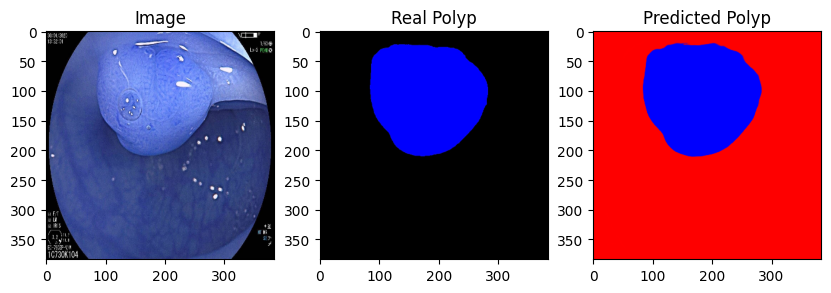

1/1 [==============================] - 0s 17ms/step


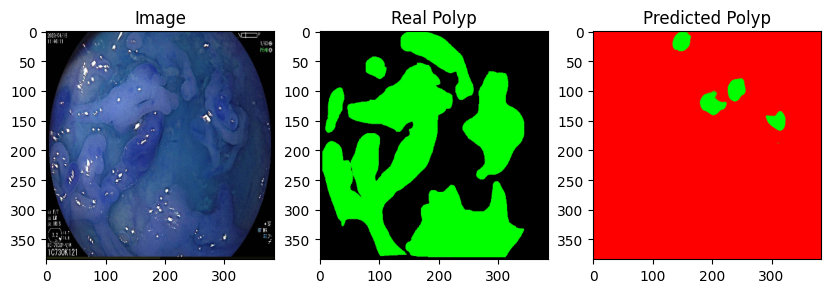

1/1 [==============================] - 0s 18ms/step


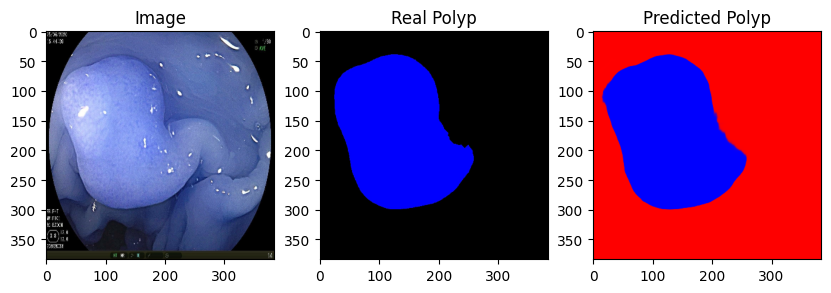

1/1 [==============================] - 0s 22ms/step


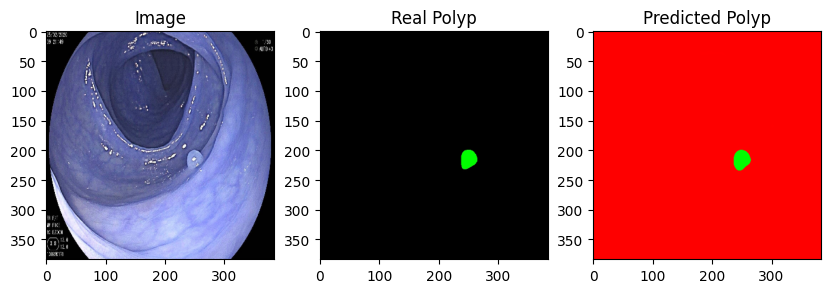

1/1 [==============================] - 0s 18ms/step


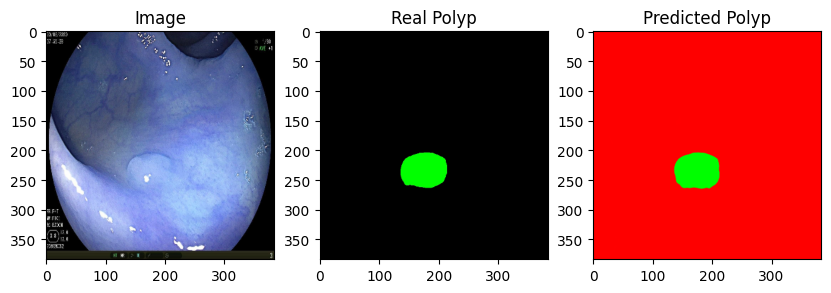

1/1 [==============================] - 0s 19ms/step


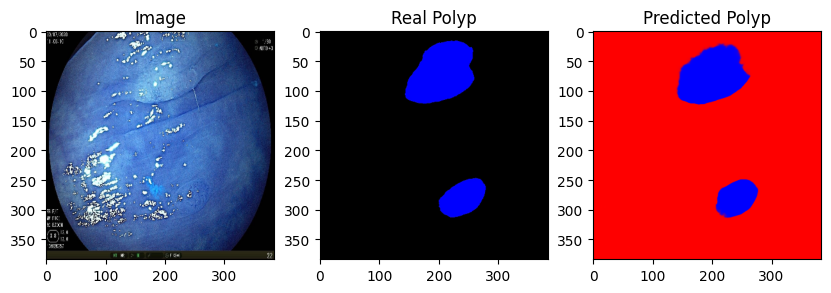

1/1 [==============================] - 0s 17ms/step


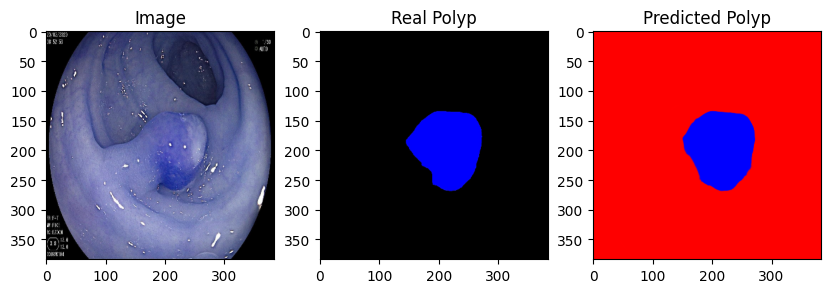

1/1 [==============================] - 0s 17ms/step


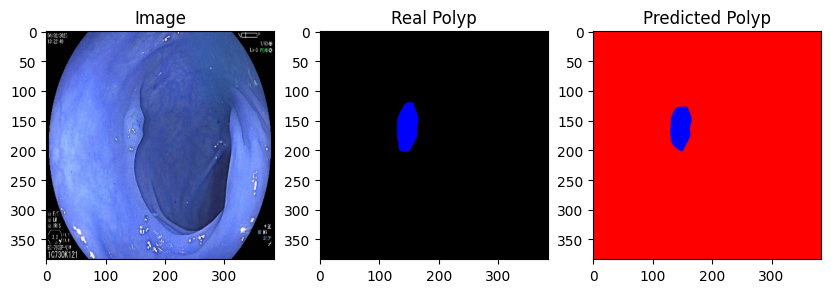

1/1 [==============================] - 0s 17ms/step


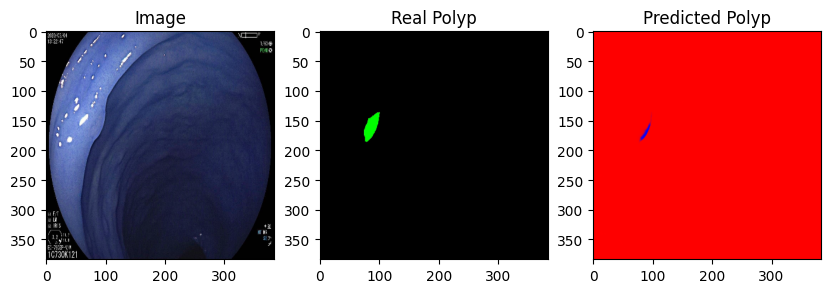

1/1 [==============================] - 0s 22ms/step


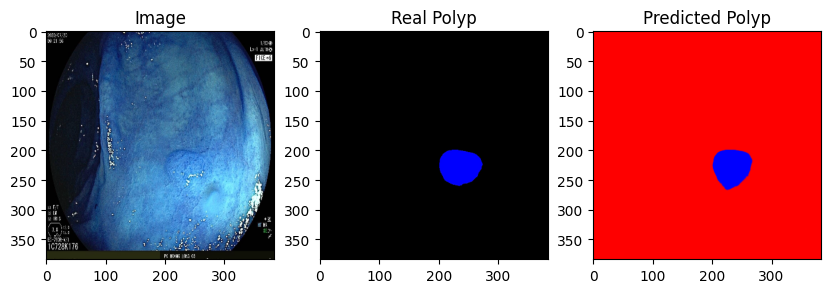

In [11]:
#Test with val data
model.load_weights("best3.hdf5")

ids = range(len(image_val))
index = random.sample(ids, 10)
w, h = 384, 384

import matplotlib.pyplot as plt

for id in index:

    # Input image
    image = cv2.imread(image_val[id])
    image = cv2.resize(image, (w, h))
    # Predict segmentation map with trained model

    mask_predict = model.predict(image[np.newaxis, :, :, :])

    # Read real mask
    image_mask = cv2.imread(mask_val[id], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (w, h))

    plt.figure(figsize=(10, 6))
    plt.subplot(131)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(132)
    plt.title("Real Polyp")
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.title("Predicted Polyp")
    z = mask_predict[0]#[:, :, 1:2]
    plt.imshow(z)
    plt.show()

1/1 [==============================] - 0s 16ms/step


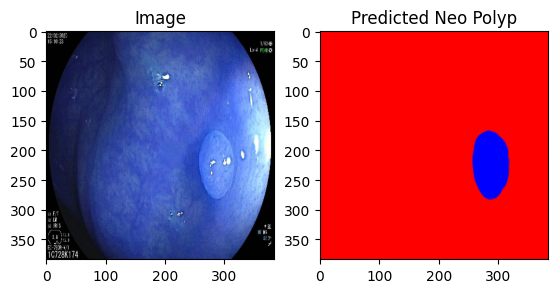

1/1 [==============================] - 0s 17ms/step


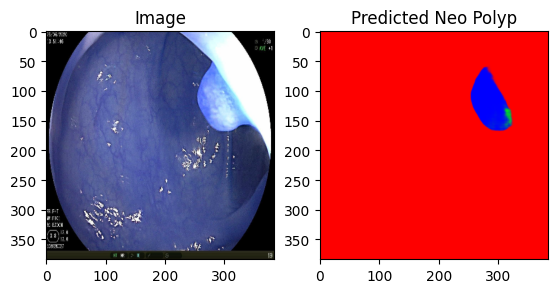

1/1 [==============================] - 0s 21ms/step


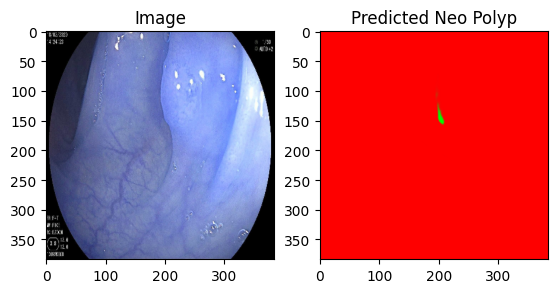

1/1 [==============================] - 0s 16ms/step


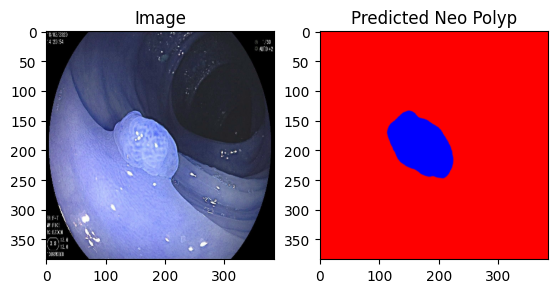

In [ ]:
#Test with test data
import matplotlib.pyplot as plt
import random

model.load_weights("checkpoint_2.hdf5")

#Test with images in test folder
test_folder = "test/test"
count = 0
num_images = 3
w, h = 384, 384

while count <= num_images:
    file = random.choice(os.listdir(test_folder))
    count += 1
    # Input image
    image_path = os.path.join(test_folder, file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (w, h))
    # Predict segmentation map with trained model

    mask_predict = model.predict(image[np.newaxis, :, :, :])

    plt.figure(figsize=(10, 6))
    plt.subplot(131)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(132)
    plt.title("Predicted Neo Polyp")
    z = mask_predict[0]#[:, :, 1]
    plt.imshow(z)
    plt.show()